# Recriar Estudo 2

In [1]:
import sys
print(sys.executable)

/home/magda/tf-gpu-env/bin/python3.10


**Ver se está a usar a GPU**

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-06-26 10:55:38.511856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-26 10:55:39.164063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6981082952762065292
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2351693824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13407334701898093553
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2025-06-26 10:55:40.073459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.092678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.092736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.233467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.233552: I tensorflow/compile

**imports**

In [3]:
import os
# Ativa o alocador assíncrono (melhora fragmentação de memória)
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf
# Ativa a alocação dinâmica de memória (não ocupa toda a memória no início)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Erro ao definir memory growth:", e)
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, ReLU, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_auc_score

print("TensorFlow:", tf.__version__)
print("TensorFlow Addons:", tfa.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

2025-06-26 10:55:40.244581: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.244697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.244736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
/home/magda/tf-gpu-env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.


TensorFlow: 2.13.0
TensorFlow Addons: 0.21.0
NumPy: 1.23.5
Pandas: 1.5.3
Matplotlib: 3.7.1


## Arquitetura do Modelo:

In [4]:
# Entrada
input_layer = Input(shape=(224, 224, 3))

# Primeira camada
x = Conv2D(48, (3,3), strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(24, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_1
for _ in range(2):
    x = Conv2D(72, (1,1), strides=1, padding='same')(x)  # 24 -> 72
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(24, (1,1), strides=1, padding='same')(x)  # 72 -> 24
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
# Expandir de novo
x = Conv2D(72, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(56, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_2
for _ in range(2):
    x = Conv2D(168, (1,1), strides=1, padding='same')(x)  # 56 -> 168
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(56, (1,1), strides=1, padding='same')(x)  # 168 -> 56
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir de novo
x = Conv2D(336, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(104, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_3
for _ in range(2):
    x = Conv2D(624, (1,1), strides=1, padding='same')(x)  # 104 -> 624
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(104, (1,1), strides=1, padding='same')(x)  # 624 -> 104
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Expandir
x = Conv2D(624, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_4
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(136, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Entre conv_blocks
x = Conv2D(816, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=5, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(272, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# ConvBlock_5
for _ in range(3):
    x = Conv2D(1632, (1,1), strides=1, padding='same')(x)  # 272 -> 1632
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(272, (1,1), strides=1, padding='same')(x)  # 1632 -> 272
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Finalização
x = Conv2D(1632, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(448, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(1280, (1,1), strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Pooling global e classificação
x = GlobalAveragePooling2D()(x)
output_layer = Dense(2, activation='softmax')(x)

# Modelo
model = Model(inputs=input_layer, outputs=output_layer)

2025-06-26 10:55:40.862556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.862673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.862774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.863111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-26 10:55:40.863127: I tensorflow/core/co

In [5]:
# Compilar o modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=2, average='macro')
    ]
)

In [6]:
# Mostrar resumo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 48)      1344      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 48)      192       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 48)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 48)      480       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 48)      192   

## Funções Auxiliares

Trata do pré-processamento das imagens, ou seja redimensiona para 224 X 224 pixels e normaliza [0,1] e coloca em one hot.

In [7]:
# Função auxiliar para carregar imagem
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

Permite analisar a distribuição dos datasets.

In [8]:
def inspect_dataset_distribution(dataset, name="dataset"):
    total_samples = 0
    label_counter = Counter()

    for images, labels in dataset:
        # labels vêm em one-hot: [0,1] ou [1,0]
        labels_np = labels.numpy()
        class_indices = labels_np.argmax(axis=1)  # <-- Corrigir: pegar o índice da classe correta
        total_samples += len(class_indices)
        label_counter.update(class_indices)

    print(f"📊 {name.upper()} -> Total de imagens: {total_samples}")
    for label, count in sorted(label_counter.items()):
        perc = (count / total_samples) * 100
        print(f"  Classe {int(label)} ({'Fogo' if label == 1 else 'Sem fogo'}): {count} imagens ({perc:.2f}%)")
    print("-" * 40)

Permite analisar o histórico de trino.

In [9]:
def plot_training_history(history):
    metrics = history.history.keys()
    epochs_range = range(len(history.history['loss']))

    for metric in metrics:
        if "val_" not in metric:
            plt.figure(figsize=(10, 5))
            plt.plot(epochs_range, history.history[metric], label=f"Train {metric}")
            if f"val_{metric}" in metrics:
                plt.plot(epochs_range, history.history[f"val_{metric}"], label=f"Val {metric}")
            plt.title(f"Training and Validation {metric.capitalize()}")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.show()

Usada para avaliar o modelo, ou seja, se está a prever corretamente a classificação das imagens.

In [10]:
def avaliar_modelo(model, dataset):
    # 1. Previsões e rótulos reais
    y_pred_probs = model.predict(dataset, verbose=0)
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = (y_pred_probs[:, 1] > 0.5).astype(int)

    # 2. Contagem das classes
    TP = np.sum((y_true_int == 1) & (y_pred_int == 1))
    TN = np.sum((y_true_int == 0) & (y_pred_int == 0))
    FP = np.sum((y_true_int == 0) & (y_pred_int == 1))
    FN = np.sum((y_true_int == 1) & (y_pred_int == 0))

    total = TP + TN + FP + FN

    # 3. Cálculo das métricas com base nas fórmulas
    accuracy   = (TP + TN) / total if total > 0 else 0.0
    precision  = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall     = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score   = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    auc        = roc_auc_score(y_true_int, y_pred_probs[:, 1])

    # Categorical crossentropy loss
    eps = 1e-7
    p = np.clip(y_pred_probs, eps, 1 - eps)
    y = y_true
    loss = -np.mean(np.sum(y * np.log(p), axis=1))

    # Métricas específicas de detecção de incêndio
    fdr = recall * 100  # ou (TP / (TP + FN)) * 100
    ewr = ((FP + FN) / total) * 100 if total > 0 else 0.0

    # 4. Impressão
    print("=== MÉTRICAS DE AVALIAÇÃO ===")
    print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1_score:.4f}")
    print(f"AUC            : {auc:.4f}")
    print(f"Loss    : {loss:.4f}")
    print(f"FDR (Fire Detection Rate)      : {fdr:.2f} %")
    print(f"EWR (Error Warning Rate)       : {ewr:.2f} %")
    print("Confusion Matrix:")
    print(np.array([[TN, FP], [FN, TP]]))  # [[negativos reais], [positivos reais]]

    # 5. Retorno opcional
    return {
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc': auc,
        'loss': loss,
        'fdr': fdr,
        'ewr': ewr,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

## Treino

In [11]:
# Configurações gerais
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 50
SEED = 42

In [12]:
data = pd.read_csv("../Datasets/Estudo2_Recriado.csv")
data = data[['image_path', 'label_bi']]
data['label_bi'] = data['label_bi'].astype(str)

In [13]:
# Dividir em treino, validação e teste (80/10/10)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['label_bi'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['label_bi'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Criar datasets TensorFlow
# Generator com aumentações para treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=160,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='reflect',
    cval=125
)

# Apenas normalização para validação
val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
callback = [
    ModelCheckpoint('Recriar_Estudo_2_Aug_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',   # automaticamente faz one-hot
    color_mode='rgb',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label_bi',
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 4492 validated image filenames belonging to 2 classes.
Found 561 validated image filenames belonging to 2 classes.
Found 562 validated image filenames belonging to 2 classes.


In [17]:
## Treinar
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callback
)

Epoch 1/50


2025-06-26 10:55:51.801851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-06-26 10:55:53.120191: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x65403f1dbb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-26 10:55:53.120237: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-06-26 10:55:53.127243: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-26 10:55:53.251836: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-26 10:55:53.392087: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.25GiB with freed_by_count=0. The c

281/281 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.7794 - precision: 0.7794 - recall: 0.7794 - auc: 0.8424 - f1_score: 0.7768
Epoch 1: val_loss improved from inf to 0.69510, saving model to Recriar_Estudo_2_Aug_best.h5


/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 [==============================] - 82s 190ms/step - loss: 0.5067 - accuracy: 0.7794 - precision: 0.7794 - recall: 0.7794 - auc: 0.8424 - f1_score: 0.7768 - val_loss: 0.6951 - val_accuracy: 0.4920 - val_precision: 0.4920 - val_recall: 0.4920 - val_auc: 0.4920 - val_f1_score: 0.3297
Epoch 2/50
281/281 [==============================] - ETA: 0s - loss: 0.4206 - accuracy: 0.8215 - precision: 0.8215 - recall: 0.8215 - auc: 0.8874 - f1_score: 0.8196
Epoch 2: val_loss did not improve from 0.69510
281/281 [==============================] - 50s 177ms/step - loss: 0.4206 - accuracy: 0.8215 - precision: 0.8215 - recall: 0.8215 - auc: 0.8874 - f1_score: 0.8196 - val_loss: 0.9905 - val_accuracy: 0.4920 - val_precision: 0.4920 - val_recall: 0.4920 - val_auc: 0.6171 - val_f1_score: 0.3297
Epoch 3/50
281/281 [==============================] - ETA: 0s - loss: 0.3782 - accuracy: 0.8442 - precision: 0.8442 - recall: 0.8442 - auc: 0.9074 - f1_score: 0.8427
Epoch 3: val_loss improved from 0.69510 t

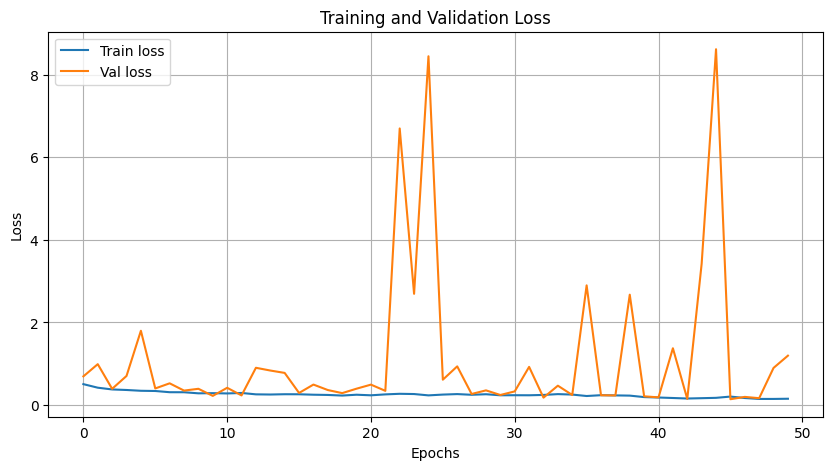

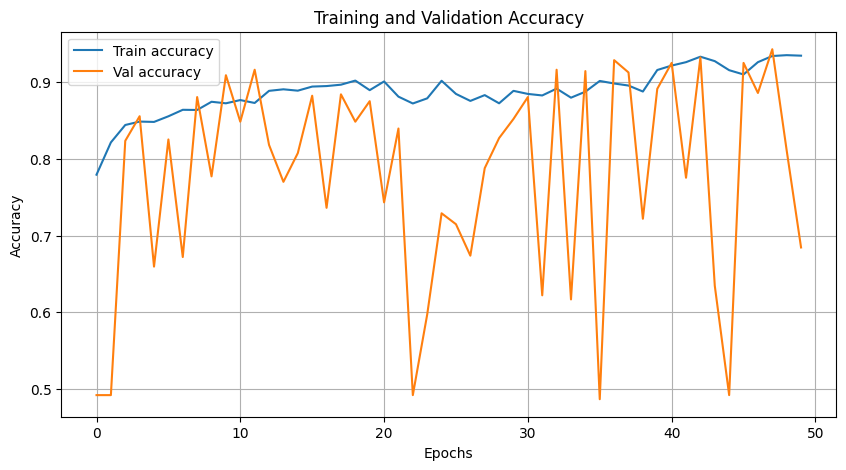

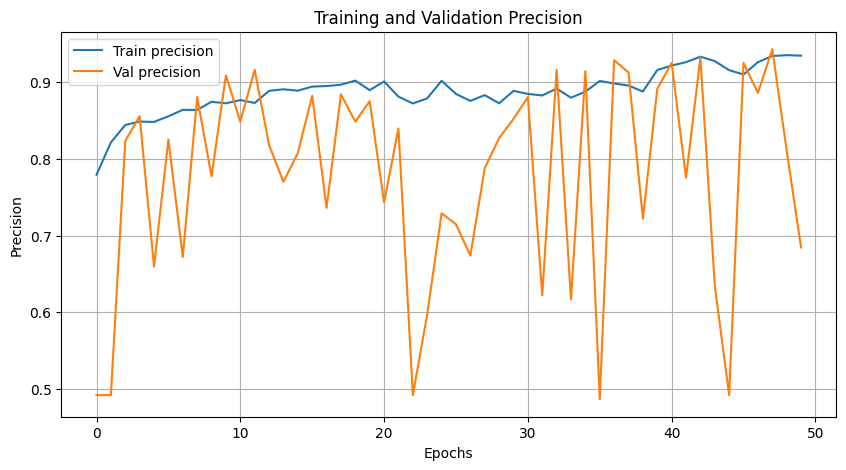

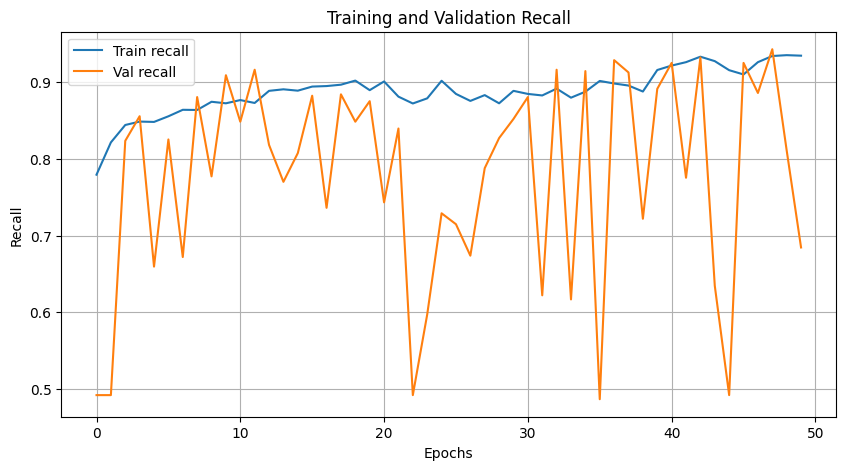

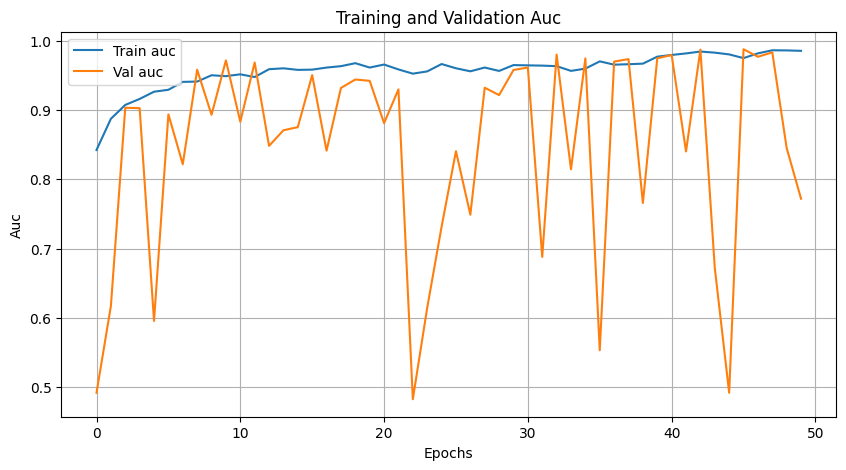

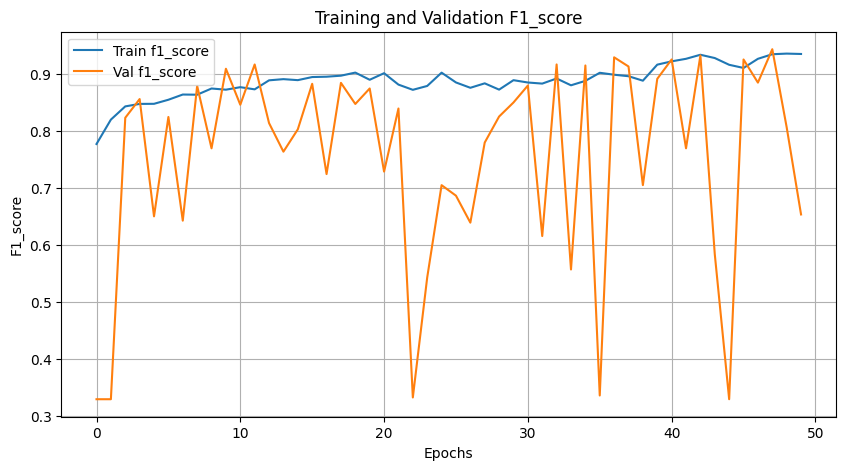

In [18]:
plot_training_history(history)

In [19]:
# Converter o histórico em DataFrame
history = pd.DataFrame(history.history)
# Salvar em CSV
history.to_csv('Recriar_Estudo_2_Aug_train_history.csv', index=False)

In [20]:
model.save('Recriar_Estudo_2_Aug.h5')

/home/magda/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Avaliar

In [21]:
avaliar_modelo(model, test_generator, ig=True)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=91, TN=276, FP=0, FN=195
Accuracy       : 0.6530
Precision      : 1.0000
Recall         : 0.3182
F1-Score       : 0.4828
AUC            : 0.9341
Binary Loss    : 1.3758
FDR (Fire Detection Rate)      : 31.82 %
EWR (Error Warning Rate)       : 34.70 %
Confusion Matrix:
[[276   0]
 [195  91]]


{'TP': 91,
 'TN': 276,
 'FP': 0,
 'FN': 195,
 'accuracy': 0.6530249110320284,
 'precision': 1.0,
 'recall': 0.3181818181818182,
 'f1_score': 0.4827586206896552,
 'auc': 0.9340605047126787,
 'loss': 1.375813719530278,
 'fdr': 31.818181818181817,
 'ewr': 34.69750889679715,
 'confusion_matrix': array([[276,   0],
        [195,  91]])}

In [22]:
model_best = load_model('Recriar_Estudo_2_Aug_best.h5')

In [23]:
avaliar_modelo(model_best, test_generator, ig=True)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=280, TN=247, FP=29, FN=6
Accuracy       : 0.9377
Precision      : 0.9061
Recall         : 0.9790
F1-Score       : 0.9412
AUC            : 0.9935
Binary Loss    : 0.1199
FDR (Fire Detection Rate)      : 97.90 %
EWR (Error Warning Rate)       : 6.23 %
Confusion Matrix:
[[247  29]
 [  6 280]]


{'TP': 280,
 'TN': 247,
 'FP': 29,
 'FN': 6,
 'accuracy': 0.9377224199288257,
 'precision': 0.9061488673139159,
 'recall': 0.9790209790209791,
 'f1_score': 0.9411764705882353,
 'auc': 0.9935137326441674,
 'loss': 0.11990661767163976,
 'fdr': 97.9020979020979,
 'ewr': 6.227758007117438,
 'confusion_matrix': array([[247,  29],
        [  6, 280]])}

## Testar no FLAME train

In [24]:
data = pd.read_csv("../Datasets/FLAME_train.csv")
image_paths_flame_train = data['image_path'].values
labels_flame_train = data['label_bi'].values

test_ds_flame_train = tf.data.Dataset.from_tensor_slices((image_paths_flame_train, labels_flame_train))
test_ds_flame_train = test_ds_flame_train.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_train, name="FLAME train")

📊 FLAME TRAIN -> Total de imagens: 39375
  Classe 0 (Sem fogo): 14357 imagens (36.46%)
  Classe 1 (Fogo): 25018 imagens (63.54%)
----------------------------------------


In [25]:
avaliar_modelo(model, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=13254, TN=14357, FP=0, FN=11764
Accuracy       : 0.7012
Precision      : 1.0000
Recall         : 0.5298
F1-Score       : 0.6926
AUC            : 0.9687
Binary Loss    : 0.9565
FDR (Fire Detection Rate)      : 52.98 %
EWR (Error Warning Rate)       : 29.88 %
Confusion Matrix:
[[14357     0]
 [11764 13254]]


{'TP': 13254,
 'TN': 14357,
 'FP': 0,
 'FN': 11764,
 'accuracy': 0.701231746031746,
 'precision': 1.0,
 'recall': 0.5297785594372052,
 'f1_score': 0.6926212374581939,
 'auc': 0.9687082373895504,
 'loss': 0.9565292220251006,
 'fdr': 52.97785594372052,
 'ewr': 29.876825396825396,
 'confusion_matrix': array([[14357,     0],
        [11764, 13254]])}

In [26]:
avaliar_modelo(model_best, test_ds_flame_train)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=24755, TN=12930, FP=1427, FN=263
Accuracy       : 0.9571
Precision      : 0.9455
Recall         : 0.9895
F1-Score       : 0.9670
AUC            : 0.9963
Binary Loss    : 0.0926
FDR (Fire Detection Rate)      : 98.95 %
EWR (Error Warning Rate)       : 4.29 %
Confusion Matrix:
[[12930  1427]
 [  263 24755]]


{'TP': 24755,
 'TN': 12930,
 'FP': 1427,
 'FN': 263,
 'accuracy': 0.9570793650793651,
 'precision': 0.9454969062714842,
 'recall': 0.9894875689503557,
 'f1_score': 0.9669921874999999,
 'auc': 0.9963363746633453,
 'loss': 0.09259116008228085,
 'fdr': 98.94875689503557,
 'ewr': 4.292063492063492,
 'confusion_matrix': array([[12930,  1427],
        [  263, 24755]])}

## Testar no FLAME test

In [27]:
data = pd.read_csv("../Datasets/FLAME_test.csv")
image_paths_flame_test = data['image_path'].values
labels_flame_test = data['label_bi'].values

test_ds_flame_test = tf.data.Dataset.from_tensor_slices((image_paths_flame_test, labels_flame_test))
test_ds_flame_test = test_ds_flame_test.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_flame_test, name="FLAME test")

📊 FLAME TEST -> Total de imagens: 8617
  Classe 0 (Sem fogo): 3480 imagens (40.39%)
  Classe 1 (Fogo): 5137 imagens (59.61%)
----------------------------------------


In [28]:
avaliar_modelo(model, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=1217, TN=3474, FP=6, FN=3920
Accuracy       : 0.5444
Precision      : 0.9951
Recall         : 0.2369
F1-Score       : 0.3827
AUC            : 0.7854
Binary Loss    : 1.9476
FDR (Fire Detection Rate)      : 23.69 %
EWR (Error Warning Rate)       : 45.56 %
Confusion Matrix:
[[3474    6]
 [3920 1217]]


{'TP': 1217,
 'TN': 3474,
 'FP': 6,
 'FN': 3920,
 'accuracy': 0.5443889984913542,
 'precision': 0.9950940310711366,
 'recall': 0.2369087015767958,
 'f1_score': 0.3827044025157233,
 'auc': 0.785357665483007,
 'loss': 1.947619504916361,
 'fdr': 23.69087015767958,
 'ewr': 45.56110015086457,
 'confusion_matrix': array([[3474,    6],
        [3920, 1217]])}

In [29]:
avaliar_modelo(model_best, test_ds_flame_test)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=4704, TN=2435, FP=1045, FN=433
Accuracy       : 0.8285
Precision      : 0.8182
Recall         : 0.9157
F1-Score       : 0.8642
AUC            : 0.9363
Binary Loss    : 0.3220
FDR (Fire Detection Rate)      : 91.57 %
EWR (Error Warning Rate)       : 17.15 %
Confusion Matrix:
[[2435 1045]
 [ 433 4704]]


{'TP': 4704,
 'TN': 2435,
 'FP': 1045,
 'FN': 433,
 'accuracy': 0.8284785888360218,
 'precision': 0.8182292572621326,
 'recall': 0.915709558107845,
 'f1_score': 0.8642292853205953,
 'auc': 0.9363263253520212,
 'loss': 0.32204345195115347,
 'fdr': 91.57095581078451,
 'ewr': 17.152141116397818,
 'confusion_matrix': array([[2435, 1045],
        [ 433, 4704]])}

## Testar no UAVS Raw Images

In [30]:
data = pd.read_csv("../Datasets/UAVS_RawImages.csv")
image_paths_uavs_raw = data['image_path'].values
labels_uavs_raw = data['label_bi'].values

test_ds_uavs_raw = tf.data.Dataset.from_tensor_slices((image_paths_uavs_raw, labels_uavs_raw))
test_ds_uavs_raw = test_ds_uavs_raw.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_raw, name="UAVS Raw Images")

📊 UAVS RAW IMAGES -> Total de imagens: 1643
  Classe 0 (Sem fogo): 498 imagens (30.31%)
  Classe 1 (Fogo): 1145 imagens (69.69%)
----------------------------------------


In [31]:
avaliar_modelo(model, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=496, TN=490, FP=8, FN=649
Accuracy       : 0.6001
Precision      : 0.9841
Recall         : 0.4332
F1-Score       : 0.6016
AUC            : 0.5703
Binary Loss    : 3.8126
FDR (Fire Detection Rate)      : 43.32 %
EWR (Error Warning Rate)       : 39.99 %
Confusion Matrix:
[[490   8]
 [649 496]]


{'TP': 496,
 'TN': 490,
 'FP': 8,
 'FN': 649,
 'accuracy': 0.6001217285453438,
 'precision': 0.9841269841269841,
 'recall': 0.4331877729257642,
 'f1_score': 0.6015767131594907,
 'auc': 0.5703214605145472,
 'loss': 3.8125708019987217,
 'fdr': 43.31877729257642,
 'ewr': 39.98782714546561,
 'confusion_matrix': array([[490,   8],
        [649, 496]])}

In [32]:
avaliar_modelo(model_best, test_ds_uavs_raw)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=564, TN=409, FP=89, FN=581
Accuracy       : 0.5922
Precision      : 0.8637
Recall         : 0.4926
F1-Score       : 0.6274
AUC            : 0.5506
Binary Loss    : 3.2335
FDR (Fire Detection Rate)      : 49.26 %
EWR (Error Warning Rate)       : 40.78 %
Confusion Matrix:
[[409  89]
 [581 564]]


{'TP': 564,
 'TN': 409,
 'FP': 89,
 'FN': 581,
 'accuracy': 0.5922093730979915,
 'precision': 0.8637059724349158,
 'recall': 0.4925764192139738,
 'f1_score': 0.6273637374860958,
 'auc': 0.5506269619964574,
 'loss': 3.233496618127821,
 'fdr': 49.25764192139738,
 'ewr': 40.77906269020085,
 'confusion_matrix': array([[409,  89],
        [581, 564]])}

## Testar no UAVS Augmented Images

In [33]:
data = pd.read_csv("../Datasets/UAVS_AugmentedImages.csv")
image_paths_uavs_aug = data['image_path'].values
labels_uavs_aug = data['label_bi'].values

test_ds_uavs_aug = tf.data.Dataset.from_tensor_slices((image_paths_uavs_aug, labels_uavs_aug))
test_ds_uavs_aug = test_ds_uavs_aug.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_uavs_aug, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 15560
  Classe 0 (Sem fogo): 7780 imagens (50.00%)
  Classe 1 (Fogo): 7780 imagens (50.00%)
----------------------------------------


In [34]:
avaliar_modelo(model, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=2747, TN=7444, FP=336, FN=5033
Accuracy       : 0.6549
Precision      : 0.8910
Recall         : 0.3531
F1-Score       : 0.5058
AUC            : 0.4303
Binary Loss    : 4.1573
FDR (Fire Detection Rate)      : 35.31 %
EWR (Error Warning Rate)       : 34.51 %
Confusion Matrix:
[[7444  336]
 [5033 2747]]


{'TP': 2747,
 'TN': 7444,
 'FP': 336,
 'FN': 5033,
 'accuracy': 0.6549485861182519,
 'precision': 0.8910152448913397,
 'recall': 0.3530848329048843,
 'f1_score': 0.5057534750989597,
 'auc': 0.43033749446540803,
 'loss': 4.157313014076329,
 'fdr': 35.30848329048843,
 'ewr': 34.505141388174806,
 'confusion_matrix': array([[7444,  336],
        [5033, 2747]])}

In [35]:
avaliar_modelo(model_best, test_ds_uavs_aug)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=2265, TN=5542, FP=2238, FN=5515
Accuracy       : 0.5017
Precision      : 0.5030
Recall         : 0.2911
F1-Score       : 0.3688
AUC            : 0.3806
Binary Loss    : 2.9363
FDR (Fire Detection Rate)      : 29.11 %
EWR (Error Warning Rate)       : 49.83 %
Confusion Matrix:
[[5542 2238]
 [5515 2265]]


{'TP': 2265,
 'TN': 5542,
 'FP': 2238,
 'FN': 5515,
 'accuracy': 0.5017352185089974,
 'precision': 0.502998001332445,
 'recall': 0.2911311053984576,
 'f1_score': 0.36880240983473095,
 'auc': 0.3806485715796221,
 'loss': 2.936279648614302,
 'fdr': 29.11311053984576,
 'ewr': 49.826478149100254,
 'confusion_matrix': array([[5542, 2238],
        [5515, 2265]])}

## Testar no FireMan

In [36]:
data = pd.read_csv("../Datasets/FireMan_test.csv")
image_paths_fireman = data['image_path'].values
labels_fireman = data['label_bi'].values

test_ds_fireman = tf.data.Dataset.from_tensor_slices((image_paths_fireman, labels_fireman))
test_ds_fireman = test_ds_fireman.map(preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

inspect_dataset_distribution(test_ds_fireman, name="UAVS Augmented Images")

📊 UAVS AUGMENTED IMAGES -> Total de imagens: 589
  Classe 0 (Sem fogo): 33 imagens (5.60%)
  Classe 1 (Fogo): 556 imagens (94.40%)
----------------------------------------


In [37]:
avaliar_modelo(model, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=0, TN=33, FP=0, FN=556
Accuracy       : 0.0560
Precision      : 0.0000
Recall         : 0.0000
F1-Score       : 0.0000
AUC            : 1.0000
Binary Loss    : 8.6301
FDR (Fire Detection Rate)      : 0.00 %
EWR (Error Warning Rate)       : 94.40 %
Confusion Matrix:
[[ 33   0]
 [556   0]]


{'TP': 0,
 'TN': 33,
 'FP': 0,
 'FN': 556,
 'accuracy': 0.05602716468590832,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'auc': 1.0,
 'loss': 8.630121815184381,
 'fdr': 0.0,
 'ewr': 94.39728353140917,
 'confusion_matrix': array([[ 33,   0],
        [556,   0]])}

In [38]:
avaliar_modelo(model_best, test_ds_fireman)

=== MÉTRICAS DE AVALIAÇÃO ===
TP=21, TN=33, FP=0, FN=535
Accuracy       : 0.0917
Precision      : 1.0000
Recall         : 0.0378
F1-Score       : 0.0728
AUC            : 0.9948
Binary Loss    : 7.3431
FDR (Fire Detection Rate)      : 3.78 %
EWR (Error Warning Rate)       : 90.83 %
Confusion Matrix:
[[ 33   0]
 [535  21]]


{'TP': 21,
 'TN': 33,
 'FP': 0,
 'FN': 535,
 'accuracy': 0.09168081494057725,
 'precision': 1.0,
 'recall': 0.03776978417266187,
 'f1_score': 0.07279029462738301,
 'auc': 0.9948223239590145,
 'loss': 7.343141876553235,
 'fdr': 3.776978417266187,
 'ewr': 90.83191850594228,
 'confusion_matrix': array([[ 33,   0],
        [535,  21]])}